<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/TrainCNN_B%26W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Install, Import, Login

##Setup for W&B Tool

In [28]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install wandb
# import wandb
# from wandb.keras import WandbCallback
## 075552994aad288a1162d4ab06f96040112fd54c
# wandb.login()

# wandb.init()
# config = wandb.config

## Import Libraries

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
import sys
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
import itertools
import time
import shutil
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [30]:
# # To save static image with plotly
# %%capture
# !pip install kaleido
# !pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [31]:
!pip install -U kaleido
#need to restart runtime after install kaleido
import kaleido
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Calculate execution time

In [32]:
start_time = time.time()

# 📈 Preparing the data
We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The batch size is set fairly low for now (32) for all images to fit in memory. The seed is for reproducibility.

##Create dataset functions

In [53]:
def createTrain_and_Test_Dataset(directory,BATCH_SIZE,VAL_SPLIT,IMAGE_HEIGHT, IMAGE_WIDTH, MODE):
  # Make a dataset containing the training spectrograms
  train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory,
                                            labels='inferred',
                                            batch_size=BATCH_SIZE,
                                            validation_split=VAL_SPLIT,
                                            subset='training',
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)

  # Make a dataset containing the validation spectrogram
  valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory,
                                            labels='inferred',
                                            batch_size=BATCH_SIZE,
                                            validation_split=VAL_SPLIT,
                                            subset='validation',
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)
  return train_dataset, valid_dataset

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We convert input from int to float32 and rescale it from the (0, 255) range to the (0,1) range.

## Rescale data size as [256, 256]

In [54]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    
    # flip_and_rotate = tf.keras.Sequential([
    #     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    # ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    # if augment == True, do ImageAugmentation
    # if augment: 
    #   ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

# 🧠 Define the Model and Train

## Define Model Architecture 🦾

In [55]:
def make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES):
  # Create CNN model with 3 Convolution Layer Architecture
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
  # Conv2D(NumFilter, FilterSize, option...)
  # 1
  model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')) #kernel_initializer='he_uniform'
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  # 2
  model.add(tf.keras.layers.Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  # 3
  model.add(tf.keras.layers.Conv2D(128, (3, 3),strides=(1, 1), padding='same', activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  # 4
  model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  # flattening
  model.add(tf.keras.layers.Flatten())
  # NN 
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
  return model

## Plot results function

In [56]:
def plotResults(history,SaveFile,outputPath):
  # Plot the loss curves for training and validation.
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values)+1)
  
  d = {'Train Loss': loss_values, 'Test Loss': val_loss_values, 'Epochs':epochs}
  df = pd.DataFrame(d)
  
  fig = go.Figure()
  fig = make_subplots(rows=2, cols=1,
                      subplot_titles=("Training and Validation Loss", "Training and Validation Accuracy"))

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Train Loss'],
      name="Training Loss",       # this sets its legend entry
      mode='lines+markers'
  ),1,1),

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Test Loss'],
      name="Validation Loss",
      mode='lines+markers'
  ),1,1),

  # Plot the accuracy curves for training and validation.
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(acc_values)+1)

  d = {'Train Accuracy': acc_values, 'Test Accuracy': val_acc_values, 'Epochs':epochs}
  df = pd.DataFrame(d)

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Train Accuracy'],
      name="Training Accuracy",       # this sets its legend entry
      mode='lines+markers'
  ),2,1),

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Test Accuracy'],
      name="Validation Accuracy",
      mode='lines+markers'
  ),2,1),

  # edit axis labels
  fig['layout']['xaxis']['title']='Epochs'
  fig['layout']['xaxis2']['title']='Epochs'
  fig['layout']['yaxis']['title']='Loss'
  fig['layout']['yaxis2']['title']='Accuracy'

  # Tick Distance
  fig['layout']['xaxis']['dtick']= 5
  fig['layout']['xaxis2']['dtick']= 5
  # First value on x axis
  fig['layout']['xaxis']['tick0']= 0
  fig['layout']['xaxis2']['tick0']= 0
  # Tick Mode
  fig['layout']['xaxis']['tickmode']= 'linear'
  fig['layout']['xaxis2']['tickmode']= 'linear'

  fig.update_layout(
      height=800, 
      width=1200,
      title="Loss and Accuracy",
      legend_title="Dataset",
      font=dict(size=14)
  )

  return fig, loss_values, val_loss_values, acc_values, val_acc_values

In [57]:
# OLD FUNCTION (UNUSED)

# def plotResults(history,SaveFile,outputPath):
#   # Plot the loss curves for training and validation.
#   history_dict = history.history
#   loss_values = history_dict['loss']
#   val_loss_values = history_dict['val_loss']
#   epochs = range(1, len(loss_values)+1)

#   plt.figure(figsize=(10,15))
#   plt.subplot(211)
#   plt.plot(epochs, loss_values, 'g', label='Training loss')
#   plt.plot(epochs, loss_values, 'go')
#   plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
#   plt.plot(epochs, val_loss_values, 'bo')
#   plt.title('Training and validation loss')
#   plt.xlabel('Epochs')
#   plt.ylabel('Loss')
#   plt.legend()
#   plt.show()

#   # Plot the accuracy curves for training and validation.
#   acc_values = history_dict['accuracy']
#   val_acc_values = history_dict['val_accuracy']
#   epochs = range(1, len(acc_values)+1)

#   plt.figure(figsize=(10,15))
#   plt.subplot(221)
#   plt.plot(epochs, acc_values, 'g', label='Training accuracy')
#   plt.plot(epochs, acc_values, 'go')
#   plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
#   plt.plot(epochs, val_acc_values, 'bo')
#   plt.title('Training and validation accuracy')
#   plt.xlabel('Epochs')
#   plt.ylabel('Accuracy')
#   plt.legend()
#   plt.show()

#   if SaveFile == True:
#     AccLossPngOutput = os.path.join(outputPath,'results.png')
#     plt.savefig(AccLossPngOutput, bbox_inches='tight')
#     plt.close()
#     print('Image Saved')

# 3. 🛫 Compute Code

##Task Name 📛

In [58]:
TASK = '60EP_full_3Conv_Batch32_prova'

##Select Input and Output ⏏

In [59]:
directory = '/content/drive/MyDrive/DatasetTesi/outputSpectrogram/Mel-Spectrogram/provaClass_PDoffDbs_VS_HS'
outputPath = '/content/drive/MyDrive/DatasetTesi/outputSpectrogram/Mel-Spectrogram/Risultati_PDoffDbs_VS_HS'
outputPath = os.path.join(outputPath,TASK)

if not os.path.exists(outputPath):
   # Create a new directory because it does not exist
   os.makedirs(outputPath)
   print("The output folder has been created!")

## Define Parameters for Training

In [60]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32 # 8, 16, 32, 64, 128, 256
EPOCHS = 3
VAL_SPLIT = 0.2
MODE = 'grayscale' #rgb, rgba or grayscale, convert the image to have 1, 3 or 4 channels
SaveFile = True

##Select channels and classes, split the dataset

In [61]:
# Select number of channels
if MODE == 'grayscale':
  N_CHANNELS = 1
elif MODE == 'rgb':
  N_CHANNELS = 3
elif MODE == 'rgba':
  N_CHANNELS = 4

# Create the dataset and select number of classes
[train_dataset, valid_dataset] = createTrain_and_Test_Dataset(directory,BATCH_SIZE,VAL_SPLIT,IMAGE_HEIGHT, IMAGE_WIDTH, MODE)

classNames = train_dataset.class_names
N_CLASSES = len(classNames)

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

Found 1816 files belonging to 2 classes.
Using 1453 files for training.
Found 1816 files belonging to 2 classes.
Using 363 files for validation.


## Set Optimizer and Loss Function ♟
### LOSS FUNCTION
see: 
* tf.keras.losses

### OPTIMIZERS 
See: 
* tf.keras.optimizers.RMSprop()
* tf.keras.optimizers.SGD
* tf.keras.optimizers.Adam

We introduce **Early Stopping**, which has the following parameters:
* min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* patience: Number of epochs with no improvement after which training will be stopped
* mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.

We also introduce **ModelCheckpoint**, which save in a specified path the model that achieved the best results and **ReduceLROnPlateau**, which reduce learning rate when a metric has stopped improving.




In [65]:
monitorValue = 'val_loss'
monitorMode = 'min'

bestModelName = os.path.join(outputPath,'.best_mdl.h5')
earlyStopping = EarlyStopping(monitor=monitorValue, 
                              patience=10, 
                              verbose=0, 
                              mode=monitorMode,
                              restore_best_weights=True)

mcp_save = ModelCheckpoint(filepath=outputPath,
                           save_best_only=True, 
                           monitor=monitorValue, 
                           mode=monitorMode)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1, patience=4, 
                                   verbose=0, min_delta=1e-4, mode='min')

LOSS = 'sparse_categorical_crossentropy'
# OPTIMIZER = tf.keras.optimizers.SGD(
#         learning_rate=0.01,
#         momentum=0.0,
#         nesterov=False,
#         name='SGD')

## Train the network 💪


### Make Model

In [66]:
# wandb.config = {
#   "learning_rate": 0.001,
#   "epochs": EPOCHS,
#   "batch_size": BATCH_SIZE,
#   "architecture": "CNN"
# }

model = make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES)
# Compile model
model.compile(
    loss = LOSS,
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

### Train Model

In [67]:
# wandb.init()

# Train model and capture the history
history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data = valid_dataset,
                    callbacks = [earlyStopping, mcp_save, reduce_lr_loss]
                    )

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.6992

46/46 [==============================] - 392s 8s/step - loss: 0.7959 - accuracy: 0.6992 - val_loss: 1.0081 - val_accuracy: 0.4628 - lr: 0.0010
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7777

46/46 [==============================] - 394s 8s/step - loss: 0.5559 - accuracy: 0.7777 - val_loss: 0.7280 - val_accuracy: 0.4628 - lr: 0.0010
Epoch 3/3
46/46 [==============================] - 388s 8s/step - loss: 0.4574 - accuracy: 0.7970 - val_loss: 0.8613 - val_accuracy: 0.4848 - lr: 0.0010


## Plot results 🛬 

In [71]:
fig, loss_values, val_loss_values, acc_values, val_acc_values = plotResults(history,SaveFile,outputPath)
fig.show()

## Save plot

In [72]:
# Save pic in HTML
if SaveFile == True:
  AccLossPngOutput = os.path.join(outputPath,'results.html')
  fig.write_html(AccLossPngOutput)
  print('Image Saved')

Image Saved


In [73]:
# Convert HTML in PNG and export to Google Drive
resultImg = f"{outputPath}"+'/results.png'
fig.to_image(format="png", engine="kaleido");
fig.write_image(resultImg)

##Export Results to Google Drive 💯

In [74]:
# ⭐: log metrics using wandb.log
# wandb.log({'epochs': EPOCHS,
#            'loss': loss_values,
#            'acc': acc_values, 
#            'val_loss': val_loss_values,
#            'val_acc':val_acc_values})

In [75]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.861263, final accuracy: 0.484848


In [76]:
runtime = time.time() - start_time

print('Runtime:')
print("--- %s seconds ---" % (runtime))
print("--- %s minutes ---" % ((runtime)/60))

Runtime:
--- 2052.851936817169 seconds ---
--- 34.21419894695282 minutes ---


In [77]:
# dictionary of lists  
InfoDict = {'IMAGE_HEIGHT':[IMAGE_HEIGHT], 'IMAGE_WIDTH':[IMAGE_WIDTH],
              'BATCH_SIZE': [BATCH_SIZE], 'N_CHANNELS': [N_CHANNELS], 'N_CLASSES': [N_CLASSES],
              'EPOCHS':[EPOCHS], 'VAL_SPLIT': [VAL_SPLIT], 'MODE': MODE,
              'FINAL VALIDATION LOSS': [final_loss], 'FINAL VALIDATION ACC': [final_acc],
              'RUNTIME (s)': [runtime], 'RUNTIME (min)': [runtime/60]
              }
InfoDict
dfInfo = pd.DataFrame(InfoDict)
dfInfo.index = ['CNN']
# saving the dataframe 
outputName = 'Model_Info_and_Performance.xlsx'
OutputFileName = os.path.join(outputPath,outputName)
if SaveFile == True:
  # writing to Excel
  dfInfo.to_excel(OutputFileName)

In [78]:
# dictionary of lists  
OutputDict = {'Train_ACC':acc_values, 'Train_LOSS':loss_values, 
              'Test_ACC': val_acc_values, 'Test_LOSS': val_loss_values}
dfResult = pd.DataFrame(OutputDict) 
# saving the dataframe 
outputName = 'Risultati'
OutputFileName = outputPath+'/'+outputName+'.xlsx'
dfResult.to_excel(OutputFileName) 

In [79]:
Summary = os.path.join(outputPath,'modelsummary.txt')
modelInfo = model.summary()

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

with open(Summary, 'w') as f:
  # Pass the file handle in as a lambda function to make it callable
  f.write(short_model_summary)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_108 (Ba  (None, 256, 256, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_109 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 128, 128, 64)      18496     
                                                     

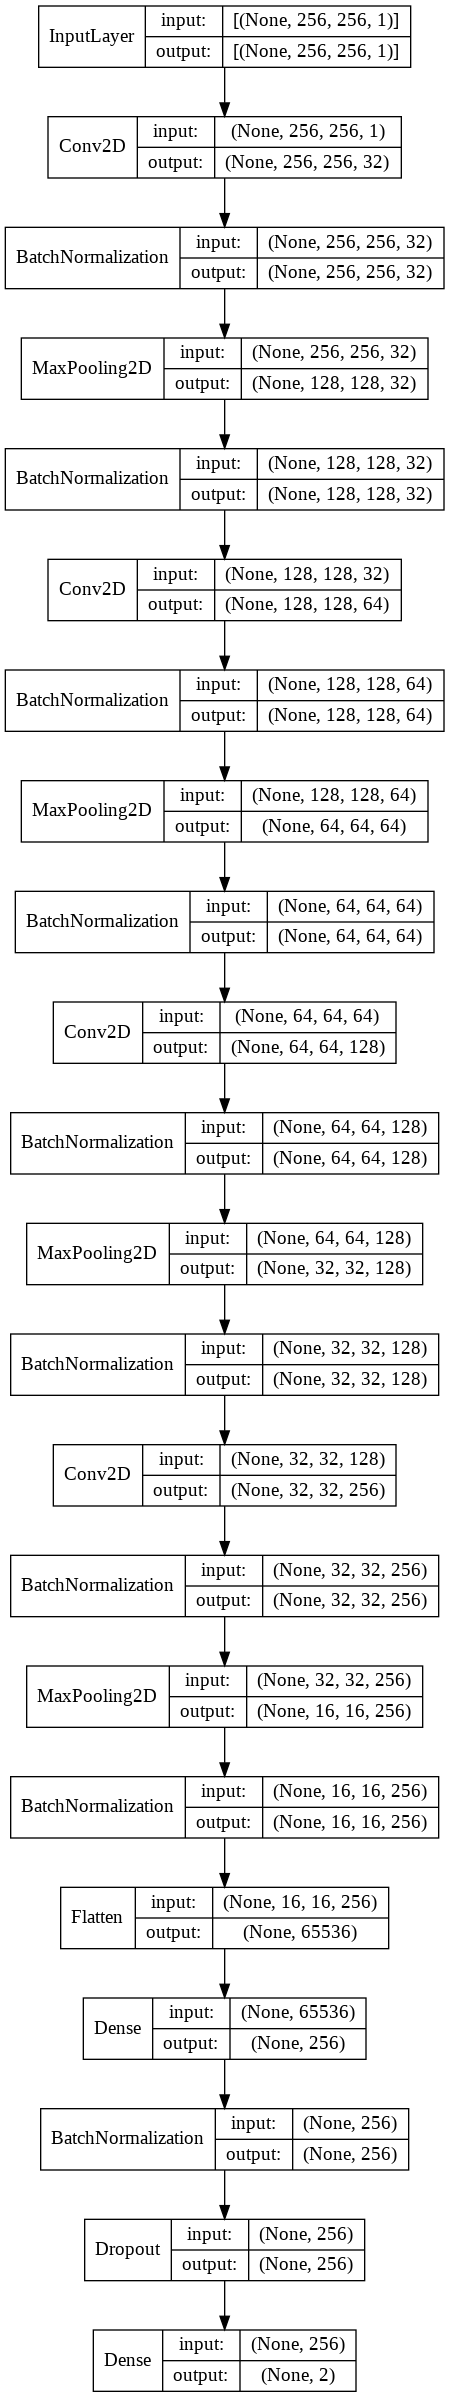

In [80]:
pngOutput = os.path.join(outputPath,'model_plot.png')
plot_model(model, to_file=pngOutput, show_shapes=True, show_layer_names=False)